In [1]:
import TTD
import utils
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
from einops import rearrange
import L1_Norm_TTD_AltConvPro
import scipy.linalg as la

In [2]:
os.getcwd()

'f:\\D\\Python\\IITGN\\Summer 2024 Research\\Tensor_Train_Decomp'

### Function

In [3]:
def AltConvPro_LP(M, rank, iterations: int = 30, tol: float = 1e-5, sigma:float = 6):
    """
    Alternating Convex Programming for matrix decomposition such that M = UV' under L1 Norm.
    ## Inputs
    M: numpy.array
        Input matrix
    rank: int
        Rank of the decomposition
    ---
    ## Outputs
    (U, V): (numpy.array, numpy.array)
        Decomposed matrices
    """

    # Initialization
    U = np.eye(M.shape[0], rank)
    S = np.eye(rank)
    V = np.zeros((M.shape[1], rank))
    W = np.ones((M.shape[0], M.shape[1]))
    losses = []
    for iter in tqdm(range(iterations)):
        # print(iter)
        # Update V
        for j in range(M.shape[1]):
            temp = LP_solve(U @ S, M[:, j], W[:, j])
            if temp is not None:
                V[j, :] = temp
        # Update U
        for j in range(M.shape[0]):
            temp = LP_solve(V @ S.T, M[j, :], W[j, :])
            if temp is not None:
                U[j, :] = temp
        # Normalization
        Nv = np.diag(V.T @ V)
        Nu = np.diag(U.T @ U)
        V = V @ np.diag(1/Nv)
        U = U @ np.diag(1/Nu)
        S = np.diag(Nu) @ S @ np.diag(Nv)
        W = np.exp(-(M - U @ S @ V.T)**2/(2*sigma**2))
        W = W/np.sum(np.sum(W, axis = 1), axis = 0)
        losses.append(np.linalg.norm((M - (U @ S @ V.T)).reshape(-1, 1), ord = 1)/np.linalg.norm(M.reshape(-1, 1), ord = 1))
        if iter == 0:
            consecutive_loss = losses[-1]
        else:
            consecutive_loss = abs(losses[-1] - losses[-2])
            if consecutive_loss < tol:
                break
        # if iter == 0:
        #     U_old = U
        #     V_old = V
        # else:
        #     if iter == 1:
        #         simU = np.diag(U.T @ U_old)/(np.linalg.norm(U, axis = 0)*np.linalg.norm(U_old, axis = 0))
        #         simV = np.diag(V.T @ V_old)/(np.linalg.norm(V, axis = 0)*np.linalg.norm(V_old, axis = 0))
        #     if all(simU > np.ones(len(simU)) - tol) and all(simV > np.ones(len(simV)) - tol):
        #         break
    return U @ S**(0.5), V @ S**(0.5), losses, W

### Accessing Files

In [52]:
dirpath1 = "../../One Interesting Project/IQ_NoisySimulatedImages20dBclutter_IQ010/"
dirpath2 = "../../One Interesting Project/IQ_NoisefreeSimulatedImages_IQ010/"

In [53]:
labels = []
for file in os.listdir(dirpath2):
    image = cv2.imread(dirpath2 + file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    labels.append(image)
labels = np.array(labels)

samples = []
for file in os.listdir(dirpath1):
    image = cv2.imread(dirpath1 + file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    samples.append(image)
samples = np.array(samples)
labels.shape, samples.shape

((1000, 84, 143), (1000, 84, 143))

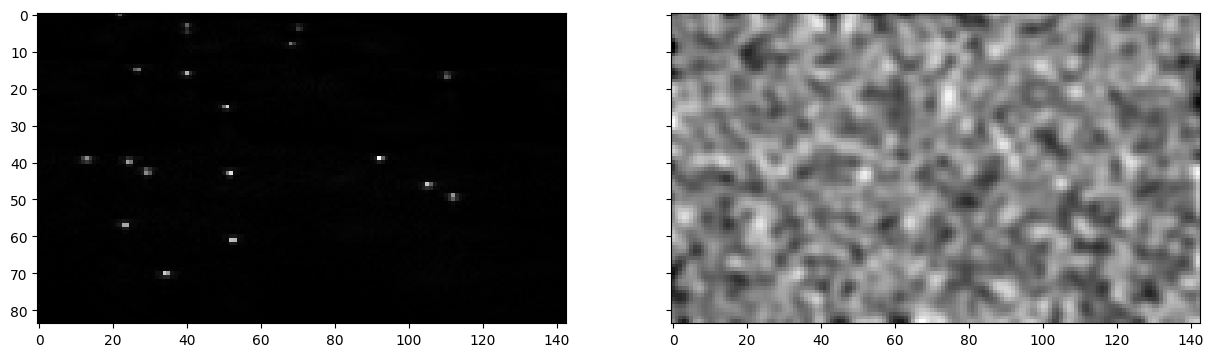

In [54]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (15, 10))
ax[0].imshow(labels[0], cmap = 'gray')
ax[1].imshow(samples[0], cmap = 'gray')
plt.show()

### Algorithm

In [55]:
num_samples = 1000
jump = 100

In [56]:
G, losses, t1 = L1_Norm_TTD_AltConvPro.L1_TTD_AltConvPro(samples[:num_samples:jump], ranks = [1, 5, 32, 1])

100%|██████████| 30/30 [03:57<00:00,  7.93s/it]


In [57]:
G_recon_l1 = TTD.TTD_reconstruct(G)
for j in range(len(G)):
    print(G[j].shape)

(1, 10, 5)
(5, 84, 32)
(32, 143, 1)


In [58]:
new_l1 = np.tensordot(G[1], G[2], axes = 1)
new_l1.shape

(5, 84, 143, 1)

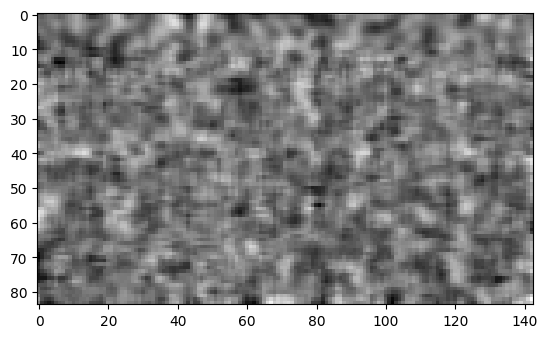

In [67]:
plt.imshow(new_l1[0].reshape(84, 143), cmap = 'gray')

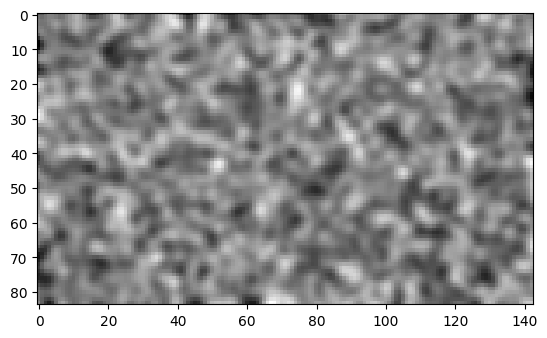

In [70]:
plt.imshow(samples[0], cmap = 'gray')

In [76]:
G_list, r, t = TTD.TTD(samples[:num_samples, :, :], 0.001, ranks = [1, 5, 32, 1])
print(r)
for j in range(len(G_list)):
    print(G_list[j].shape)

[1, 5, 32, 1]
(1, 1000, 5)
(5, 84, 32)
(32, 143, 1)


In [78]:
reconstructed = TTD.TTD_reconstruct(G_list)
np.linalg.norm(labels[:num_samples, :, :] - reconstructed)

403831.12

In [79]:
new = np.tensordot(G_list[1], G_list[2], axes = 1)

In [80]:
new.shape

(5, 84, 143, 1)

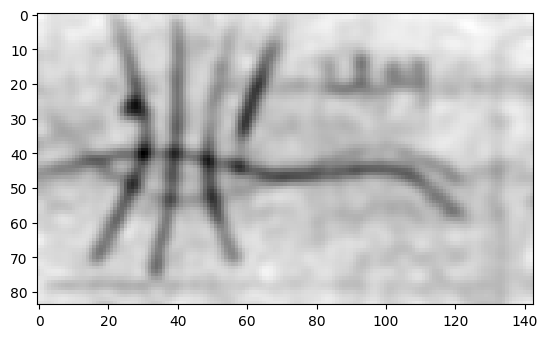

In [81]:
plt.imshow(new[0].reshape(84, 143), cmap = 'gray')

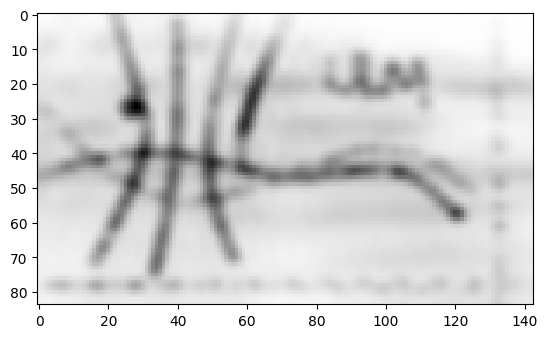

In [218]:
plt.imshow(new[0].reshape(84, 143), cmap = 'gray')

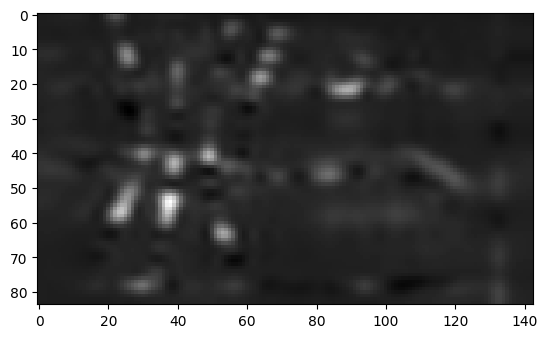

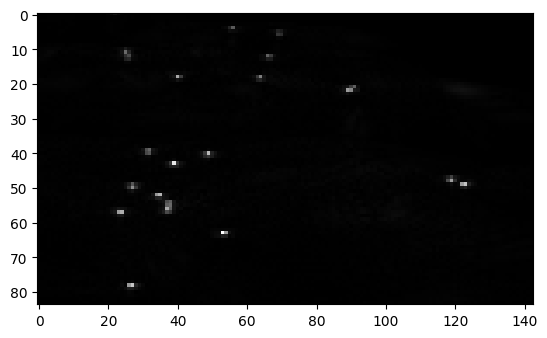

In [257]:
index = 200
plt.imshow(reconstructed[index], cmap = 'gray')
plt.show()
plt.imshow(labels[index], cmap = 'gray')
plt.show()

In [226]:
p = np.percentile(reconstructed[index],95, axis = [0, 1])

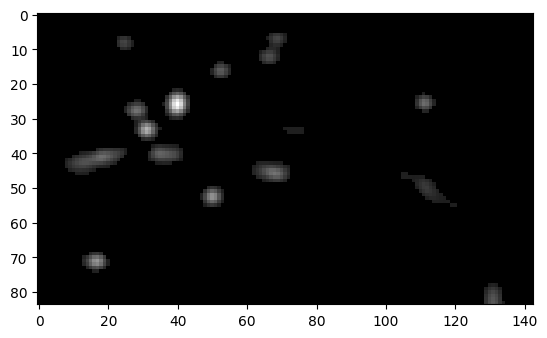

In [227]:
plt.imshow(np.where(reconstructed[index] > p, reconstructed[index], 0), cmap = 'gray')
plt.show()

In [169]:
t, h, w = samples.shape
new_samples = utils.MATLAB_reshape(samples[:num_samples, :, :], (t, -1))
U, S, V = la.svd(new_samples, full_matrices = False)

In [171]:
U = U[:, :80]
S = S[:80]
V = V[:80, :]

In [172]:
check = np.diag(S) @ V

In [176]:
check = utils.MATLAB_reshape(check, (80, h, w))

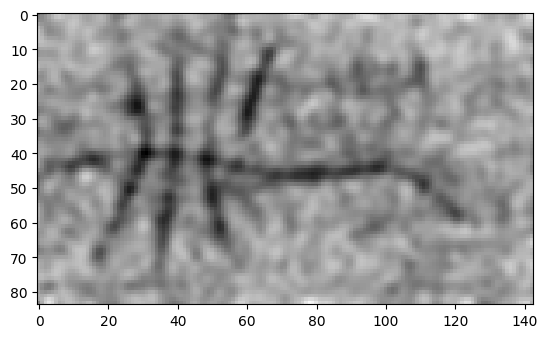

In [177]:
plt.imshow(check[0], cmap = 'gray')